In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

In [2]:
#READ IMAGES FOR CAMERA CALIBRATION
camera_calibration_folder = 'camera_cal'
files = os.listdir(camera_calibration_folder)
cal_cam_img_path = []
cal_cam_img = []
for f in files:
    fpath = os.path.join(camera_calibration_folder, f)
    if(os.path.isfile(fpath)):
        cal_cam_img_path.append(fpath)
        cal_cam_img.append(cv2.imread(fpath))

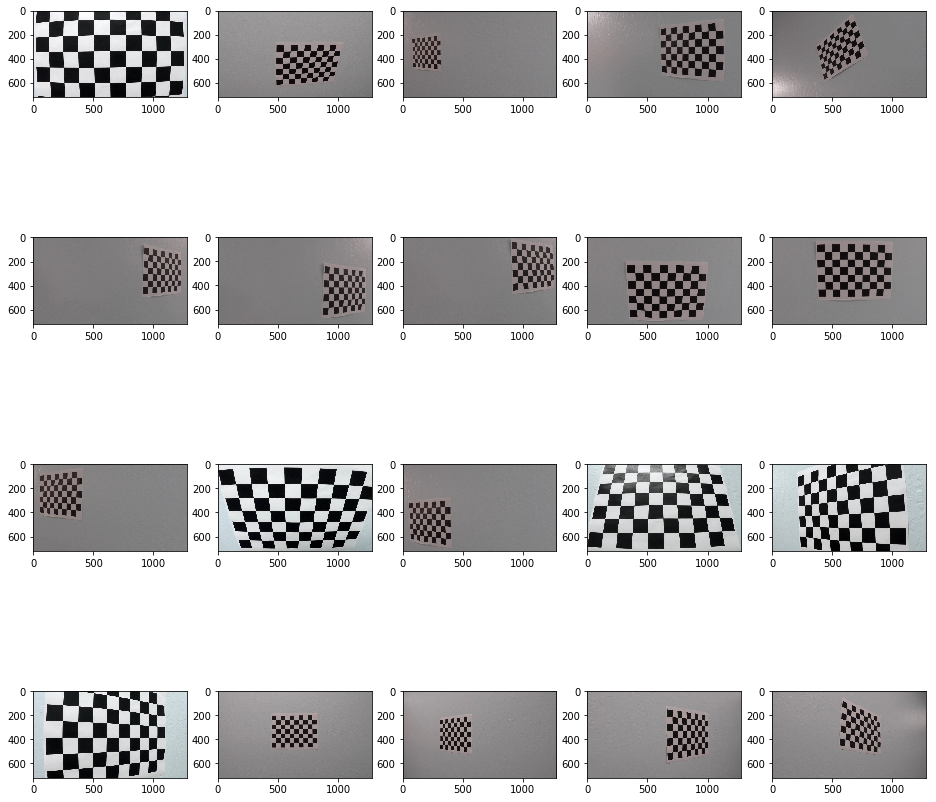

In [3]:
def show_allImg(images, col=4):
    rows = len(images)//col
    fig = plt.figure(figsize=(16, 16))
    for i in range(len(images)):
        fig.add_subplot(rows, col, i+1)
        plt.imshow(images[i])

show_allImg(cal_cam_img, col=5)

In [4]:
#DEFINE GLOBAL VALUES
NX = 9
NY = 6
offset = 100
X_size = cal_cam_img[0].shape[1]
Y_size = cal_cam_img[0].shape[0]

In [5]:
#UTILITY FUNCTION
def bgr2rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
def rgb2gray(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
def bgr2gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


### Camera Calibration

#### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  

In [6]:
#UTILITY FUNCTIONS
def finddrawChessBoardCorners(img, nx, ny, isGray=True):
    if(isGray == False):
        gray = bgr2gray(img)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if(ret == True):
        return cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    return None

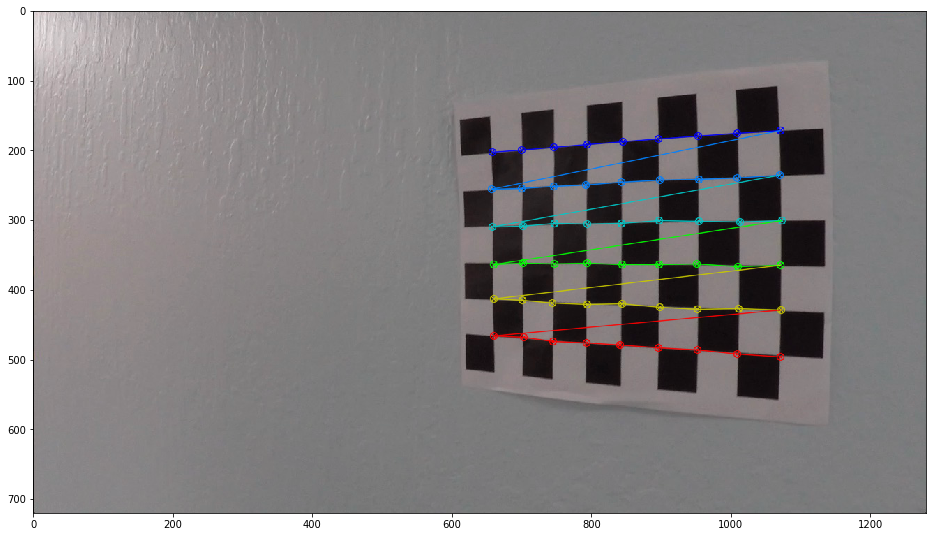

In [7]:
#SHOW CHESSBOARD CORNERS
fig = plt.figure(figsize=(16, 16))
img = finddrawChessBoardCorners(cal_cam_img[3], NX, NY, False)
plt.imshow(img)

In [8]:
#EXTRACT IMAGE POINTS AND OBJECT POINTS FOR ALL CHESSBOARD IMAGES
imgPoints = []
objPoints = []
objP = np.zeros((NX*NY, 3), np.float32)
objP[:,:2] = np.mgrid[0:NX,0:NY].T.reshape(-1, 2)

for img in cal_cam_img:
    gray = bgr2gray(img)
    ret, corners = cv2.findChessboardCorners(gray, (NX, NY), None)
    
    if(ret):
        imgPoints.append(corners)
        objPoints.append(objP)
#         img = cv2.drawChessboaxdrrdCorners(img, (NX, NY), corners, ret)



I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function. 

In [9]:
#CALIBRATE THE CAMERA AND CALCULATE THE MATRIX AND DISTORTION COEFFICIENT OF THE CAMERA
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objPoints, imgPoints, (X_size, Y_size), None, None)

#UNDISTOR IMAGE FUNCTION
def undist(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

I applied this distortion correction to the test image using the `cv2.undistort()` function and obtained this result:

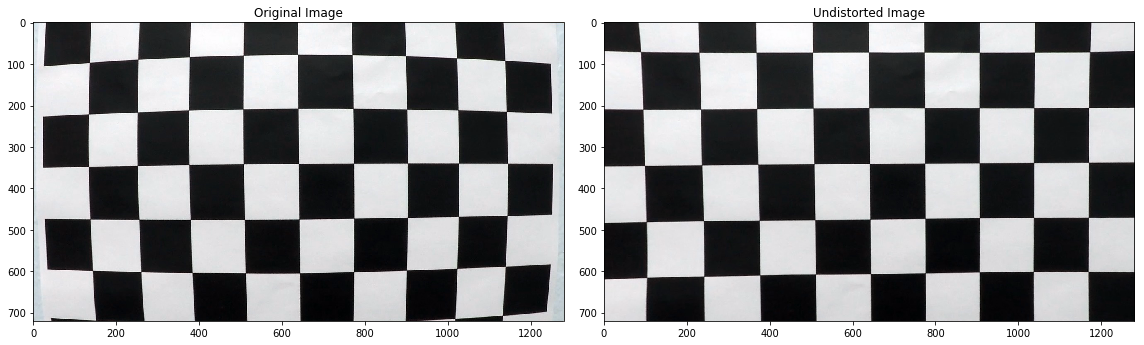

In [10]:
fig,axis = plt.subplots(1,2,figsize=(16,16))

axis[0].imshow(cal_cam_img[0])
axis[0].set_title('Original Image')
img = undist(cal_cam_img[0])
axis[1].imshow(img)
axis[1].set_title('Undistorted Image')
plt.tight_layout()

#### 1. Provide an example of a distortion-corrected image.

In this step I corrected the distortion for all the test images. The code and result is below:

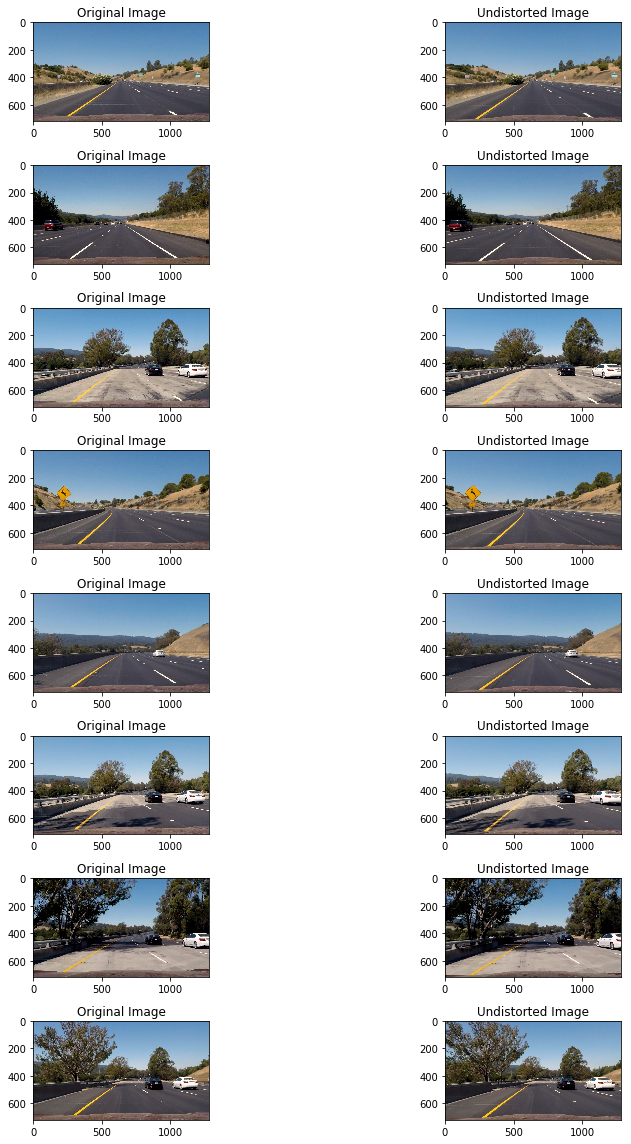

In [11]:
test_images_folder = 'test_images'
test_images_path = os.listdir(test_images_folder)
test_images = []
test_images_undist = []
fig,axis = plt.subplots(8,2,figsize=(16,16))
j = 1
for i in range(len(test_images_path)):
    path = os.path.join(test_images_folder, test_images_path[i])
    test_images.append(plt.imread(path))
    axis[i,0].imshow(test_images[i])
    axis[i,0].set_title('Original Image')
    img = undist(test_images[i])
    test_images_undist.append(img)
    axis[i,1].imshow(img)
    axis[i,1].set_title('Undistorted Image')
    plt.tight_layout()

#### 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.

I used a combination of color and gradient thresholds to generate a binary image (thresholding steps at lines # through # in `another_file.py`).  Here's an example of my output for this step.  (note: this is not actually from one of the test images)

In [12]:
#UTILITY METHODS FOR CALCULATING:

#SOBELX AND SOBELY
def sobel(img, orientation = 'x', kernel_size=3):
    if(orientation == 'x'):
        return np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = kernel_size))
    else:
        return np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = kernel_size))

#SOBEL GRADIENT
def mag_sobel(img, kernel_size = 3, thresh=[20,100]):
    sobelx = sobel(img, 'x', kernel_size)
    sobely = sobel(img, 'y', kernel_size)
    mag = np.sqrt(np.square(sobelx) + np.square(sobely))
    binary_output_mag = np.zeros_like(gray)
    scaled_mag = np.uint8(255*mag/np.max(mag))
    binary_output_mag[(scaled_mag>=thresh[0]) & (scaled_mag<=thresh[1])] = 1
    return binary_output_mag

#SOBEL MAGNITUDE
def grad_sobel(img, kernel_size = 7, thresh=[20,120]):
    sobelx = sobel(img, 'x', kernel_size)
    sobely = sobel(img, 'y', kernel_size)
    arct= np.arctan2(sobely, sobelx)
    
    binary_output_arct = np.zeros_like(gray)
    scaled_arct = np.uint8(255*arct/np.max(arct))
    
    binary_output_arct[(scaled_arct>=thresh[0]) & (scaled_arct<=thresh[1])] = 1
    return binary_output_arct

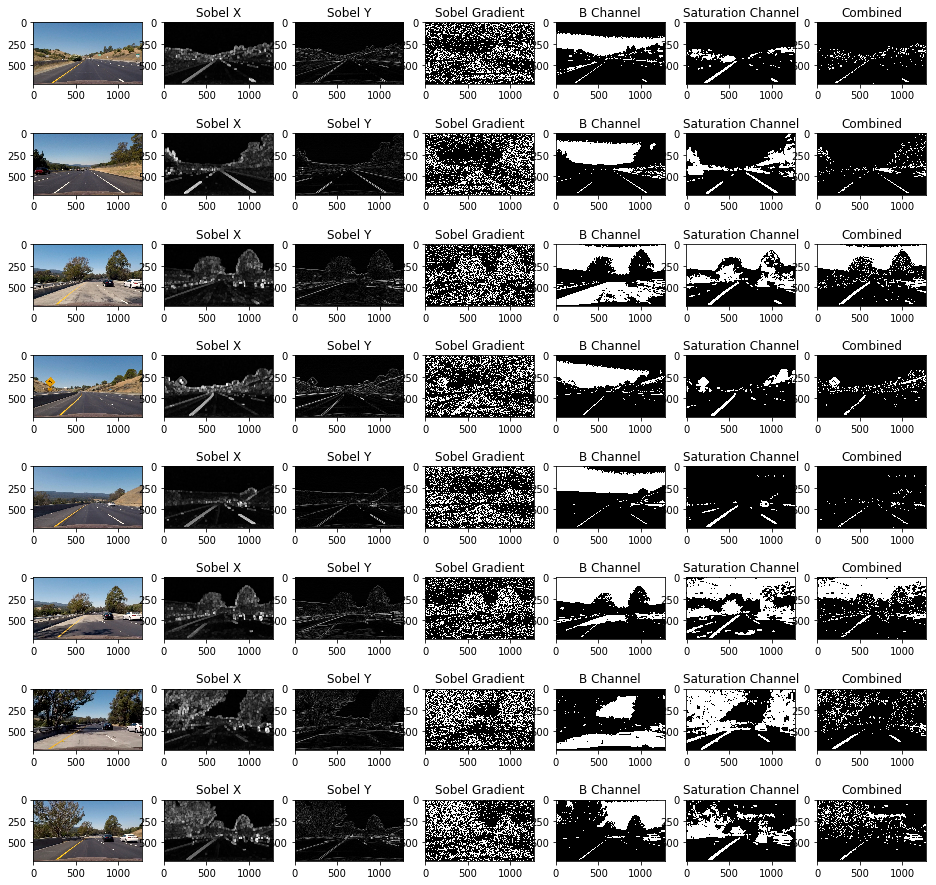

In [13]:
grayed_lanes = []
def calibrationMapAll(images, code, channel, kernel_size = 8, thresh = [20,120], isHist = False):
    if(isHist == True):
        fig, axis = plt.subplots(8, 8, figsize=(16,16))
    else:
        fig, axis = plt.subplots(8, 7, figsize=(16,16))
    for ind, img in enumerate(images):
        
        imgHLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        axis[ind, 0].imshow(img)
        kernel = np.ones((5,5),np.uint8)
        
        sobelx = sobel(gray, 'x', kernel_size)
        sobelx = cv2.dilate(sobelx, kernel, iterations = 3)
        sobely = sobel(gray, 'y', kernel_size)
        binary_output_arct = grad_sobel(gray, kernel_size, thresh)
        binary_output_mag = mag_sobel(gray, kernel_size, thresh)
        
        sobelx = cv2.dilate(sobel(gray, 'x', 31), kernel, iterations=3)
        sobelx = cv2.morphologyEx(sobelx, cv2.MORPH_CLOSE, kernel)
        axis[ind, 1].imshow(sobelx, cmap='gray')
        axis[ind, 1].set_title('Sobel X')
        
        axis[ind, 2].imshow(sobely, cmap='gray')
        axis[ind, 2].set_title('Sobel Y')
        
        axis[ind, 3].imshow(binary_output_arct, cmap='gray')
        axis[ind, 3].set_title('Sobel Gradient')
        
        lower_blue = np.array([150])
        upper_blue = np.array([255])
        bChannel = img[:,:,1]
        bChannel = cv2.inRange(bChannel, lower_blue, upper_blue)
        axis[ind, 4].imshow(bChannel, cmap='gray')
        axis[ind, 4].set_title('B Channel')
        
        lower_Saturation = np.array([0,0,120])
        upper_Saturation = np.array([255, 255, 255])
        saturation = cv2.dilate(cv2.inRange(imgHLS, lower_Saturation, upper_Saturation), kernel, iterations=3)
        axis[ind, 5].imshow(saturation, cmap='gray')
        axis[ind, 5].set_title('Saturation Channel')
        
        combined = np.zeros_like(binary_output_mag)
        combined[(sobelx == 1) | ((binary_output_arct == 1) & (binary_output_mag == 1)) | (((saturation > 10) & (bChannel > 10)))] = 255
        axis[ind, 6].imshow(combined, cmap='gray')
        axis[ind, 6].set_title('Combined')
        grayed_lanes.append(combined)
    
        if(isHist == True):
            histogram = np.sum(combined[combined.shape[0]//2:,:], axis=0)
            axis[ind, 7].plot(histogram)
            axis[ind, 7].set_title('Histogram')
            half_width = np.int(histogram.shape[0]/2)
            plt.tight_layout()
        
calibrationMapAll(test_images_undist, cv2.COLOR_RGB2HLS, 2, kernel_size = 31, thresh = [30, 150])

#### 3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

The code for my perspective transform includes a function called `warper()`, which appears in lines 1 through 8 in the file `example.py` (output_images/examples/example.py) (or, for example, in the 3rd code cell of the IPython notebook).  The `warper()` function takes as inputs an image (`img`), as well as source (`src`) and destination (`dst`) points.  I chose the hardcode the source and destination points in the following manner:

```python
src = np.array([[150,720],[590, 450],[700, 450], [1250, 720]], np.float32)

dst = np.array([[200 ,720], [200  ,0], [980 ,0], [980 ,720]], np.float32)
```

This resulted in the following source and destination points:

| Source        | Destination   | 
|:-------------:|:-------------:| 
| 150, 720      | 200, 720        | 
| 590, 450      | 200, 0      |
| 700, 450     | 980, 0      |
| 1250, 720      | 980, 720        |


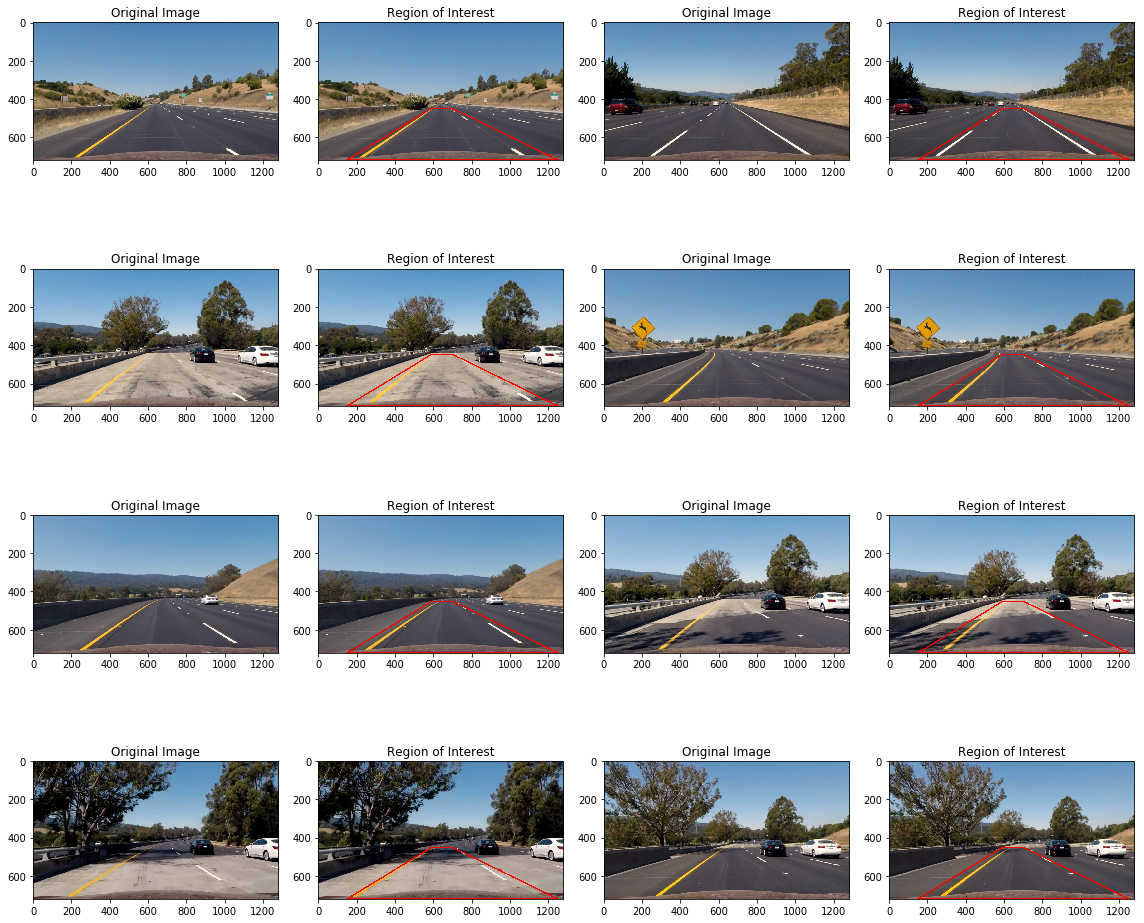

In [14]:
#VISUALIZE THE REGION OF INTEREST
ROI_PTS = np.array([[150,720],[590, 450],[700, 450], [1250, 720]], np.int32)
ROI_PTS = ROI_PTS.reshape((-1,1,2))
j = 1
fig = plt.figure(figsize = (16,16))
for img in test_images_undist:
    roi_img = np.copy(img)
    fig.add_subplot(4, 4, j)
    plt.imshow(img)
    plt.title('Original Image')
    j+=1
    fig.add_subplot(4, 4, j)
    poly_undist = cv2.polylines(roi_img, [ROI_PTS], True,(255,0,0),5)
    plt.imshow(poly_undist)
    plt.title('Region of Interest')
    j+=1
    plt.tight_layout()

#### I verified that my perspective transform was working as expected by drawing the `src` and `dst` points onto a test image and its warped counterpart to verify that the lines appear parallel in the warped image.

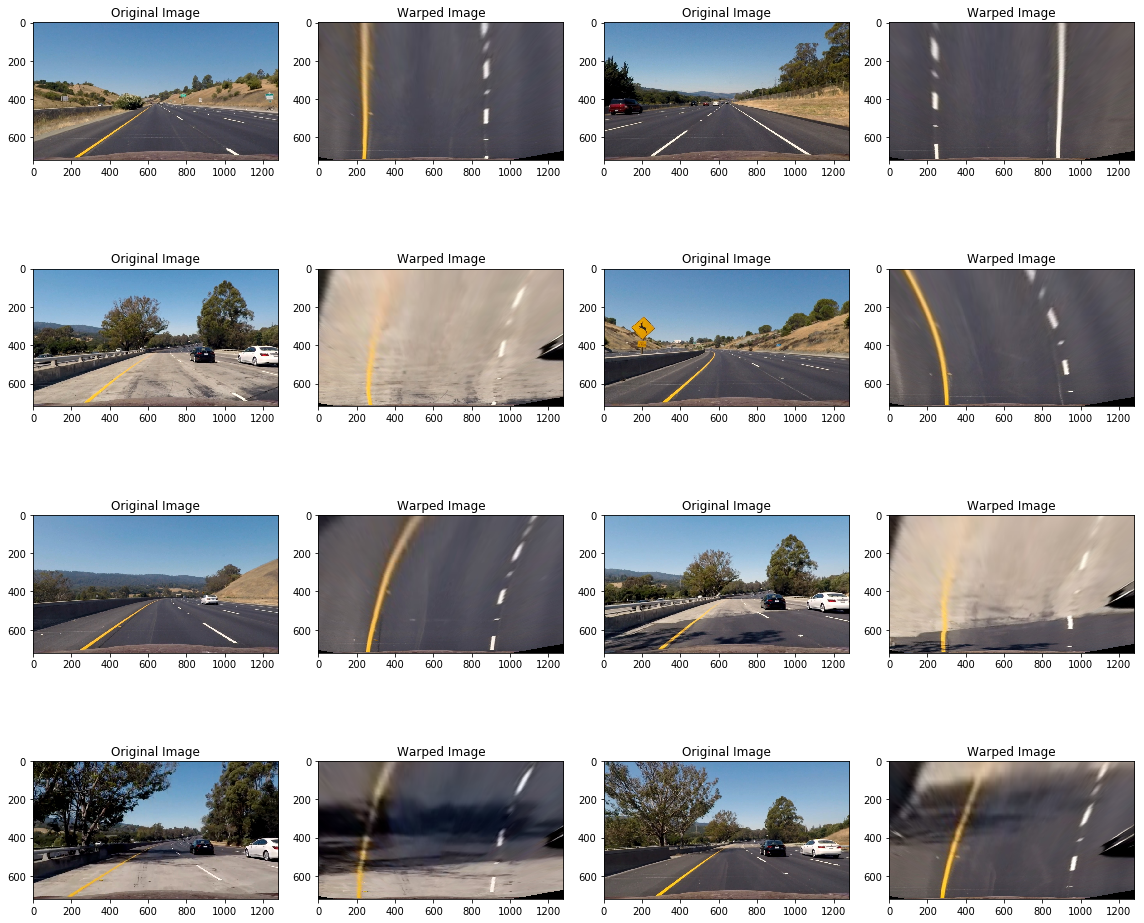

In [15]:
#WARP TEST IMAGES  
src = np.array([[150,720],[590, 450],[700, 450], [1250, 720]], np.float32)
src = src.reshape((-1,1,2))
dst = np.array([[200 ,720], [200  ,0], [980 ,0], [980 ,720]], np.float32)
dst = dst.reshape((-1,1,2))
M = cv2.getPerspectiveTransform(src, dst)
M_inv = cv2.getPerspectiveTransform(dst, src)
j = 1
fig = plt.figure(figsize = (16,16))
test_images_warped = []
for img in test_images_undist:
    roi_img = np.copy(img)
    
    fig.add_subplot(4, 4, j)
    plt.imshow(img)
    plt.title('Original Image')
    j+=1
    fig.add_subplot(4, 4, j)
    warped = cv2.warpPerspective(img, M, (X_size, Y_size), flags=cv2.INTER_LINEAR)
    test_images_warped.append(warped)
    plt.imshow(warped)
    plt.title('Warped Image')
    j+=1
    plt.tight_layout()


#### Applying the color channels on the Warped Lane lines
As we can see from the brlow results that Sobel is doing a pretty good job in detecting most of the lines followd by Saturation but saturation is having noise in many of the frames as seen below we can do AND for saturation and B channel from RGB as this removes major part of the lanes. We are also calculating AND of sobel direction and Sobel Magnitude. 

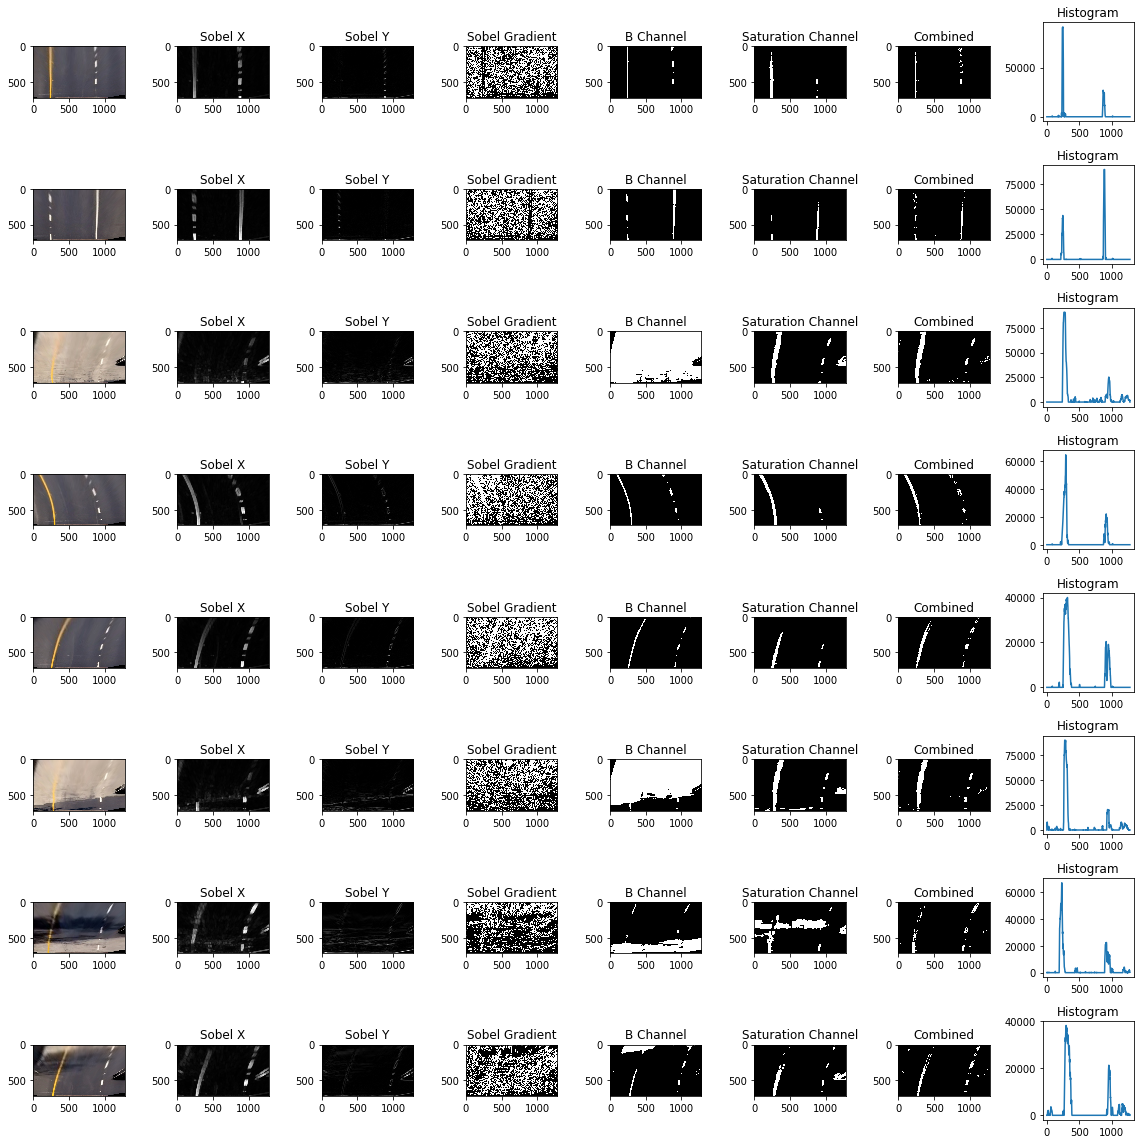

In [16]:
calibrationMapAll(test_images_warped, cv2.COLOR_RGB2HLS, 2, kernel_size = 31, thresh = [30, 150], isHist = True)

So in the final combined image we are using X_sobel OR (Sobel_Magnitude & Sobel_Gradient) OR (R & S). We are also dilating the Saturation Channel and Sobel X for getting more part of lane for more confident score. Also we are applying erosion on the combined image as this will remove the small noise near the lanes. The final code for taking a warped lane image and returning the output is below.

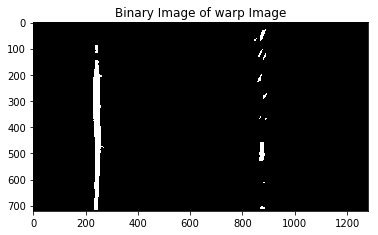

In [17]:
def getLanes(img, code = cv2.COLOR_RGB2HLS, channel=2, kernel_size = 31, thresh = [30,150]):
    
    imgHls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    kernel = np.ones((5,5),np.uint8)

    binary_output_arct = grad_sobel(gray, kernel_size, thresh)
    binary_output_mag = mag_sobel(gray, kernel_size, thresh)

    lower_blue = np.array([120])
    upper_blue = np.array([255])
    blue = img[:,:,1]
    blue = cv2.inRange(blue, lower_blue, upper_blue)

    lower_Saturation = np.array([0,0,120])
    upper_Saturation = np.array([255, 255, 255])
    saturation = cv2.dilate(cv2.inRange(imgHls, lower_Saturation, upper_Saturation), kernel, iterations=3)

    sobelx = cv2.dilate(sobel(gray, 'x', 31), kernel, iterations=3)
    sobelx = cv2.morphologyEx(sobelx, cv2.MORPH_CLOSE, kernel)

    combined = np.zeros_like(binary_output_mag)
    combined[(sobelx == 1) | ((binary_output_arct == 1) & (binary_output_mag == 1)) | (((saturation > 10) & (blue > 10)))] = 255
    return cv2.erode(combined, kernel)

plt.imshow(getLanes(test_images_warped[0]), cmap='gray')
plt.title('Binary Image of warp Image')

## 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

I used a 2nd order polynomial using the binary images with detected Lanes and minimum pixels 50. Also this function will return the visual result of applying sliding window on binary detected lanes. Code for the same is in below cells.

In [18]:
def firstFrame(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    nwindows = 9
    window_height = np.int(binary_warped.shape[0]/nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    margin = 100
    minpix = 50
    
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit, out_img

def secondFrame(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return ploty, left_fitx, right_fitx, left_lane_inds, right_lane_inds

# GET THE HIGHLIGHTED LINES
def curvesHighlight(binary_warped, left_lane_inds, right_lane_inds, left_fitx, right_fitx, ploty):
    margin = 100
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return result


#### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

I did this in below blocks by taking the left and right lines and then calculating the radius. For calculating the position I am getting the last points of the left and right line and then getting the center of the lane and by taking the difference of this with the center of the Image we are able to get the position of the image.

In [19]:
def getAvgRadius(ploty, left_fitx, right_fitx):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the radius of curvature using 2nd degree polynomial
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    avg_curve = np.mean([left_curverad, right_curverad])
    
    # Calculate the car position
    position = (left_fitx[-1:] + right_fitx[-1:])/2
    position = abs(X_size/2 - position)*xm_per_pix
    
    return avg_curve, float(position)

##### Draw the lane and radius, position text ont the image
Function to generate Polyfill from binary image, unwarp it and then plot it on the Original image along with Radius and Offset from center.

In [20]:
def unwarpedLanes(img, binary_output, l_fit, r_fit):
    #print(l_fit, r_fit)
    
    plot_y, l_fit_s, r_fit_s, left_lane_inds, right_lane_inds = secondFrame(binary_output, l_fit, r_fit)
    avg_curve, carPosition = getAvgRadius(plot_y, l_fit_s, r_fit_s)
    curveHighlight = curvesHighlight(binary_output, left_lane_inds, right_lane_inds, l_fit_s, r_fit_s, plot_y)
    
    warp_zero = np.zeros_like(binary_output).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([l_fit_s, plot_y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([r_fit_s, plot_y])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (X_size, Y_size) )
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    fontFace = 2
    text = "Radius of Curvature of the Lane: {:.0f} m".format(avg_curve)
    cv2.putText(result, text, (50,50),fontFace, 1, (255,255,255), 2)
    text = "Vehicle Position: Offset from Center with {:.2f} m".format(carPosition)
    cv2.putText(result, text, (50,100), fontFace, 1, (255,255,255), 2)
    
    return result, curveHighlight, plot_y,l_fit_s, r_fit_s

##### Image Pipeline
Function for Image pipepline. Will return result of the operations on a single Image along with Sliging window visualization.

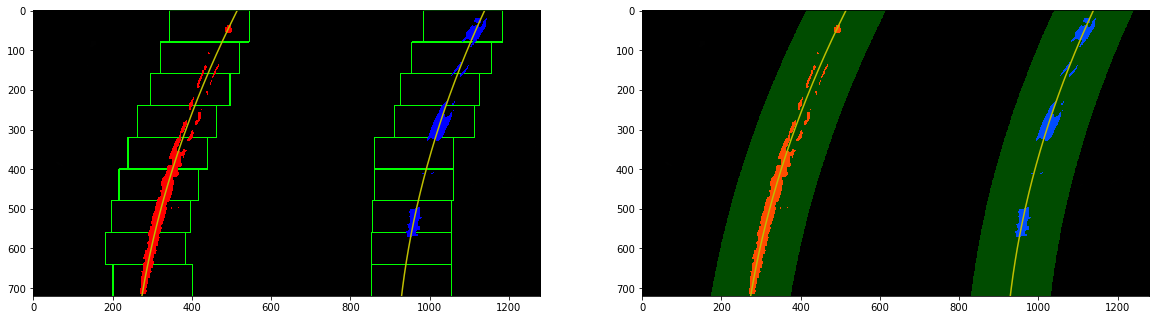

In [21]:
def returnHighlightedLane(img):
    global l_fit
    global r_fit
#     fig, axis = plt.subplots(1,2,figsize=(16,16))
    undistorted_img = undist(img)
    warped = cv2.warpPerspective(undistorted_img, M, (X_size, Y_size), flags=cv2.INTER_LINEAR)

    binary_output = getLanes(warped)
    
    l_fit, r_fit, out_img = firstFrame(binary_output)
    result, curve_highlight, ploty,l_fit_s, r_fit_s = unwarpedLanes(img, binary_output, l_fit, r_fit)
    
    resized_boxes = cv2.resize(curve_highlight,( int(X_size/8), int(Y_size/8)), interpolation = cv2.INTER_CUBIC)
    resized_warp = cv2.resize(warped,( int(X_size/8), int(Y_size/8)), interpolation = cv2.INTER_CUBIC)
    resized_binary = cv2.resize(binary_output,( int(X_size/8), int(Y_size/8)), interpolation = cv2.INTER_CUBIC)
    
    return result, out_img, ploty, l_fit_s, r_fit_s, curve_highlight
    
result, out_img, ploty, l_fit_s, r_fit_s, curve_highlight = returnHighlightedLane(test_images[7])
fig, axis = plt.subplots(1,2,figsize=(20,20))
axis[0].imshow(out_img)
axis[0].plot(l_fit_s, ploty,'y')
axis[0].plot(r_fit_s, ploty,'y')
axis[1].imshow(curve_highlight)
axis[1].plot(l_fit_s, ploty,'y')
axis[1].plot(r_fit_s, ploty,'y')


### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

I implemented this in returnHighlightedLane function and the result is in below cells.

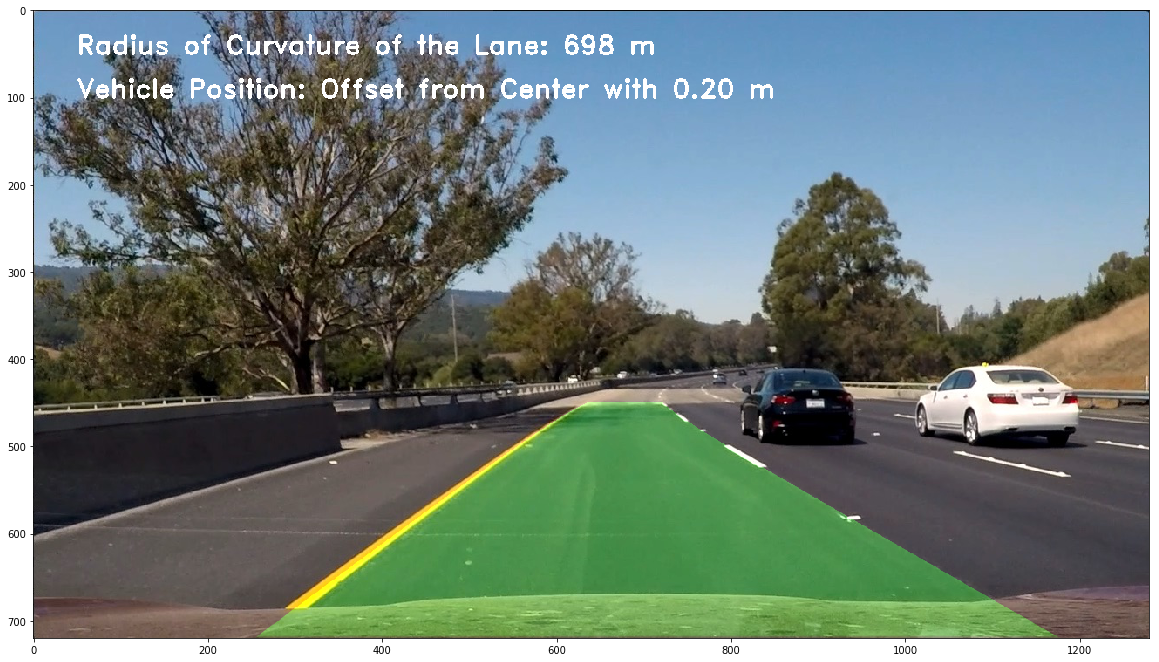

In [22]:
fig= plt.figure(figsize=(20,20))
plt.imshow(result)

---
### Pipeline (video)

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

Here's a [link to my video result](./project_video.mp4)


In [23]:
plt.figure(figsize=(16,16))
l_fit = None
r_fit = None
def pipeline(img):
    global l_fit
    global r_fit
    undistorted_img = undist(img)
    warped = cv2.warpPerspective(undistorted_img, M, (X_size, Y_size), flags=cv2.INTER_LINEAR)

    binary_output = getLanes(warped)

    l_fit, r_fit, out_img = firstFrame(binary_output)
    result, curve_highlight, ploty,l_fit_s, r_fit_s = unwarpedLanes(img, binary_output, l_fit, r_fit)
    
    curve_highlight = cv2.resize(curve_highlight,( int(X_size/8), int(Y_size/8)), interpolation = cv2.INTER_CUBIC)
    resized_warp = cv2.resize(warped,( int(X_size/8), int(Y_size/8)), interpolation = cv2.INTER_CUBIC)
    resized_binary = cv2.resize(binary_output,( int(X_size/8), int(Y_size/8)), interpolation = cv2.INTER_CUBIC)
    
    result[150:150+resized_warp.shape[0],100:100+resized_warp.shape[1]] = resized_warp
    result[150:150+resized_warp.shape[0],300:300+resized_warp.shape[1]] = np.dstack([resized_binary,resized_binary,resized_binary])
    result[150:150+resized_warp.shape[0],500:500+resized_warp.shape[1]] = curve_highlight
    return result

In [24]:
import moviepy
from moviepy.editor import VideoFileClip
video_output1 = 'output.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(38, 41)
processed_video = video_input1.fl_image(pipeline)
%time processed_video.write_videofile(video_output1, audio=False)
video_input1.reader.close()
video_input1.audio.reader.close_proc()

[MoviePy] >>>> Building video project_video_output11.mp4
[MoviePy] Writing video project_video_output11.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [09:58<00:00,  2.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output11.mp4 

Wall time: 10min


---

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

The first challenge in the process was to find the source and destination points. After several hit and trial I was able to find the good points for warp. Then finging lanes from the image was a challenge as the channels I was using were not able to detect the white lanes in shadows and concrete patches, to resolve this I used Sobel X with dilate operation so that lane lines become more intense and then eroded the combined image so that noise from the final binary image can be resolved.

Lanes are a bit fluctuating on the concrete patches. To make the pipeline more robust, we can average the lines for several frames.